In [1]:
# %% [markdown]
# # Data Check Analysis (Advanced & Best Practice)
#
# Bu notebook, gelişmiş `data_check` modülümüzü kullanarak ham veri setlerinin kalitesini kontrol eder,
# raporlar ve ek görselleştirmeler sunar.

In [2]:
# %% [markdown]
# ## 1. Kütüphane ve Modül İçe Aktarımı
#
# Burada hem yerleşik kütüphaneleri (os, sys, glob, logging, vb.) hem de
# projemize özgü modülleri (data_check, utils.logger, config_loader) import ediyoruz.

In [3]:
# Import custom modules
import os
import re
import sys
import glob
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Plotların notebook içinde gözükmesi için:
%matplotlib inline

In [5]:
# %%
# Projeye özel local script import:
sys.path.append(os.path.abspath("../source"))

In [6]:
# %%
from source.data_check import check_raw_data
from source.utils.logger import setup_logger
from source.utils.config_loader import load_config

In [7]:
# %% [markdown]
# ## 2. Konfigürasyon Yükleme ve Logger Kurulumu
#
# - `settings.yml` dosyasını yükleriz.
# - Log klasörümüzü oluşturur ve logger'ı ayarlarız.
# - Böylece tüm aşamalarda bilgi, uyarı ve hata mesajlarımız kaydedilir.

In [8]:
# %%
config_path = os.path.join(os.path.abspath("../config"), "settings.yml")
config = load_config(config_path)

if config is None:
    logging.error("Failed to load configuration. Terminating notebook.")
    sys.exit(1)

RAW_DIR = os.path.abspath(config["paths"]["raw_dir"])
LOG_DIR = config["paths"].get("logs_dir", "../logs")

print(LOG_DIR)

os.makedirs(LOG_DIR, exist_ok=True)

../logs/


In [9]:
logger = setup_logger(
    name="data_check_notebook",
    log_file=os.path.join(LOG_DIR, "data_check_notebook.log"),
    log_level=config.get("logging", {}).get("level", "INFO").upper()
)

logger.info("=== Data Check Notebook Initialized ===")
print(f"Log directory is set to: {LOG_DIR}")
print(f"Raw data directory is set to: {RAW_DIR}")

2025-01-14 17:36:45,596 - data_check_notebook - INFO - === Data Check Notebook Initialized ===


Log directory is set to: ../logs/
Raw data directory is set to: /Users/dogaaydin/PycharmProjects/Geo_Sentiment_Climate/data/raw


In [10]:
# %% [markdown]
# ## 3. Data Check İşlemi
#
# - Burada `check_raw_data` fonksiyonunu çağırarak ham veri klasörünü inceleriz.
# - Kolon kontrolü, kolon tipi kontrolü, chunk bazlı okuma, eksik veri analizi gibi işlemler yapılır.
# - Sonuçlar bir rapor CSV dosyasına kaydedilir.
# - Ayrıca log dosyasına ayrıntılar yazılır.

In [11]:
# %%
check_raw_data(raw_dir=RAW_DIR)

2025-01-14 17:36:48,385 - data_check - INFO - === Starting advanced data check ===
2025-01-14 17:36:48,399 - data_check - INFO - [MissingValues] /Users/dogaaydin/PycharmProjects/Geo_Sentiment_Climate/data/raw/epa-so2-2023/epa_so2_virginia_2023.csv, shape=(2877, 21), missing={'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': 0, 'Daily Max 1-hour SO2 Concentration': 0, 'Units': 0, 'Daily AQI Value': 0, 'Local Site Name': 352, 'Daily Obs Count': 0, 'Percent Complete': 0, 'AQS Parameter Code': 0, 'AQS Parameter Description': 0, 'Method Code': 0, 'CBSA Code': 0, 'CBSA Name': 0, 'State FIPS Code': 0, 'State': 0, 'County FIPS Code': 0, 'County': 0, 'Site Latitude': 0, 'Site Longitude': 0}
2025-01-14 17:36:48,404 - data_check - INFO - [MissingValues] /Users/dogaaydin/PycharmProjects/Geo_Sentiment_Climate/data/raw/epa-so2-2023/epa_so2_kansas_2023.csv, shape=(1350, 21), missing={'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': 0, 'Daily Max 1-hour SO2 Concentration': 0, 'Units': 0, 'Daily AQI Value': 0, 

In [ ]:
# %% [markdown]
# ## 4. Rapor Dosyasını Yükleme ve İnceleme
#
# - `processed_dir` altındaki son üretilen raporu bulur ve okuruz.
# - Raporu DataFrame olarak görüntüleriz.
# - Loglamalar sırasında rapora eklenmesi gereken eksik ya da hatalı durumlar varsa bu raporda gözükür.

In [12]:
# %%
# Find the latest report in the processed directory
processed_dir = os.path.abspath(config["paths"]["processed_dir"])
report_files = glob.glob(os.path.join(processed_dir, "data_check_report_*.csv"))

df_report = None
if not report_files:
    logger.warning("No report files found in the processed directory.")
    df_report = pd.DataFrame()
    print("No data check reports found.")
else:
    latest_report = max(report_files, key=os.path.getctime)
    logger.info(f"Loading the latest report: {latest_report}")
    print(f"Loading the latest report: {latest_report}")
    df_report = pd.read_csv(latest_report)
    display(df_report.head(10))

2025-01-14 17:38:01,808 - data_check_notebook - INFO - Loading the latest report: /Users/dogaaydin/PycharmProjects/Geo_Sentiment_Climate/data/processed/data_check_report_20250114_173652.csv


Loading the latest report: /Users/dogaaydin/PycharmProjects/Geo_Sentiment_Climate/data/processed/data_check_report_20250114_173652.csv


,file_path,pollutant,row_count,col_count,columns,missing_req_cols,missing_opt_cols,dtype_issues,empty_file,test_pass,notes,missing_values
0,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,2877,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
1,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1350,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
2,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,2327,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
3,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,360,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
4,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1398,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
5,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,2489,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
6,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1715,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
7,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,2863,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
8,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1552,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
9,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1449,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."


In [13]:
# %% [markdown]
# ## 5. Özet İstatistikler
#
# - Raporun genel istatistiklerini (`describe`) görüntüleriz.
# - Satır ve kolon sayılarını, eksik kolon durumlarını vs. gözlemleyebiliriz.

In [14]:
# %%
if df_report is not None and not df_report.empty:
    summary = df_report.describe(include='all').transpose()
    display(summary)
    print("Preview of the Data Check Report:")
    display(df_report.head())
else:
    print("DataFrame is empty. No summary available.")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
file_path,515,515,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pollutant,515,5,co,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
row_count,515.0,NaN,NaN,NaN,3786.312621,6262.875929,46.0,1023.0,2617.0,5000.0,59921.0
col_count,515.0,NaN,NaN,NaN,21.205825,0.404696,21.0,21.0,21.0,21.0,22.0
columns,515,5,"Date, Source, Site ID, POC, Daily Mean PM2.5 C...",106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_req_cols,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_opt_cols,139,4,"['Daily Max 8-hour Ozone Concentration', 'Dail...",103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dtype_issues,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
empty_file,515,1,False,515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_pass,515,1,True,515,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preview of the Data Check Report:


,file_path,pollutant,row_count,col_count,columns,missing_req_cols,missing_opt_cols,dtype_issues,empty_file,test_pass,notes,missing_values
0,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,2877,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
1,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1350,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
2,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,2327,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
3,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,360,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."
4,/Users/dogaaydin/PycharmProjects/Geo_Sentiment...,so2,1398,21,"Date, Source, Site ID, POC, Daily Max 1-hour S...",NaN,NaN,NaN,False,True,NaN,"{'Date': 0, 'Source': 0, 'Site ID': 0, 'POC': ..."


In [ ]:

# %% [markdown]
# ## 6. Gelişmiş Görselleştirmeler
#
# - Satır ve kolon sayılarını histogram ile inceleriz.
# - Quick check verilerindeki eksik kolonları tespit edip sıklık grafiği çizeriz.
# - Gerekirse ek grafikler (ör. ısı haritası, boxplot, vs.) ile veri kalitesini daha derinlemesine görselleştirebiliriz.

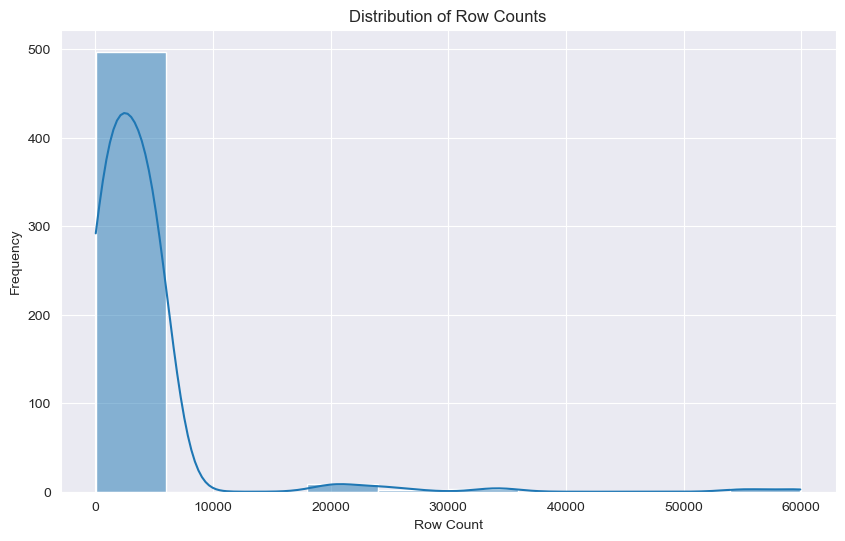

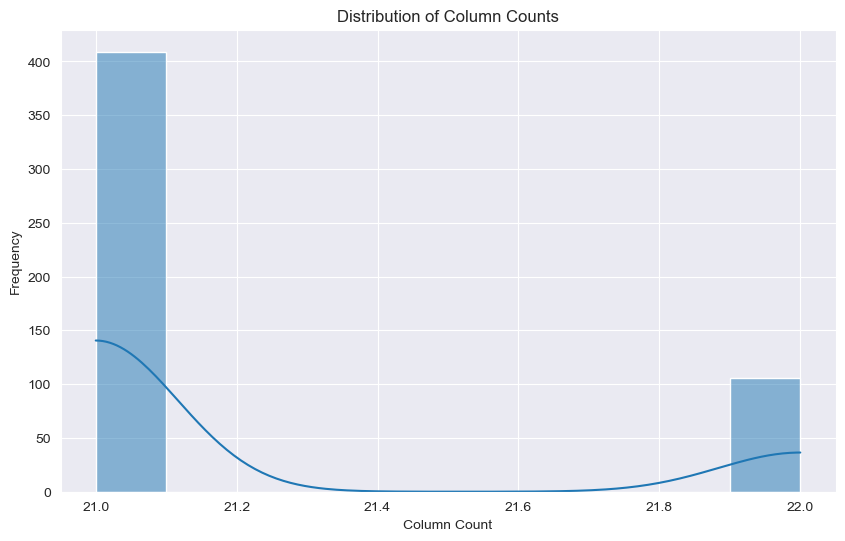

In [15]:
# %%
if df_report is not None and not df_report.empty:
    # Histogram of row_counts
    plt.figure(figsize=(10, 6))
    sns.histplot(df_report['row_count'], bins=10, kde=True)
    plt.title("Distribution of Row Counts")
    plt.xlabel("Row Count")
    plt.ylabel("Frequency")
    plt.show()

    # Histogram of col_counts
    plt.figure(figsize=(10, 6))
    sns.histplot(df_report['col_count'], bins=10, kde=True)
    plt.title("Distribution of Column Counts")
    plt.xlabel("Column Count")
    plt.ylabel("Frequency")
    plt.show()

In [16]:
# Ensure plots are rendered inline
%matplotlib inline

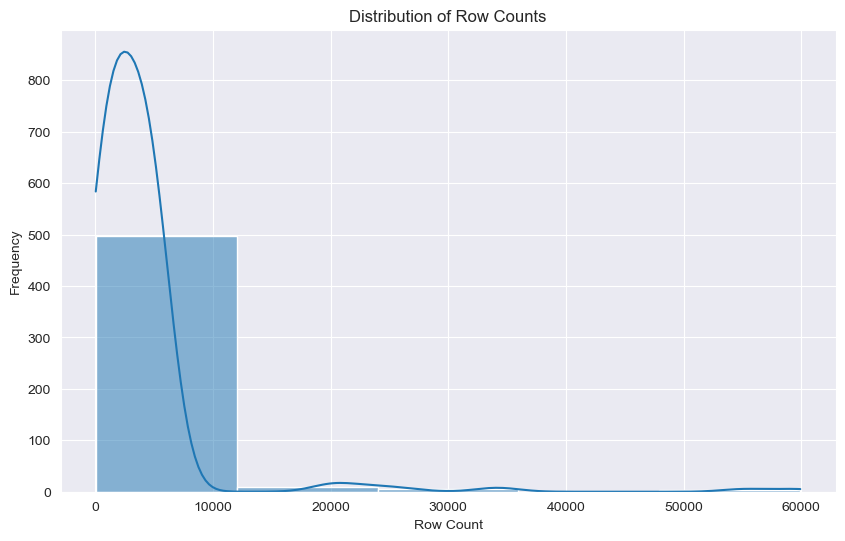

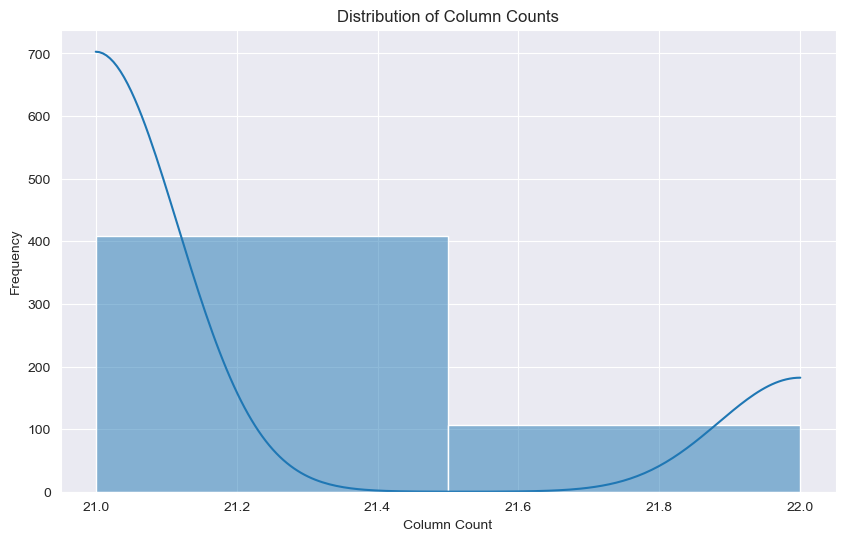

In [17]:
# Histogram of row counts
plt.figure(figsize=(10, 6))
sns.histplot(df_report['row_count'], bins=5, kde=True)
plt.title("Distribution of Row Counts")
plt.xlabel("Row Count")
plt.ylabel("Frequency")

plt.figure(figsize=(10, 6))
sns.histplot(df_report['col_count'], bins=2, kde=True)
plt.title("Distribution of Column Counts")
plt.xlabel("Column Count")
plt.ylabel("Frequency")

plt.show()

In [18]:

# %% [markdown]
# ### 5.1 Pollutant Bazlı İnceleme
#
# Data check raporunda "pollutant" sütunu (eğer `data_check.py` eklediyseniz) bulunabilir.
# Böylece hangi dosyaların hangi kirleticiye ait olduğu görülebilir.




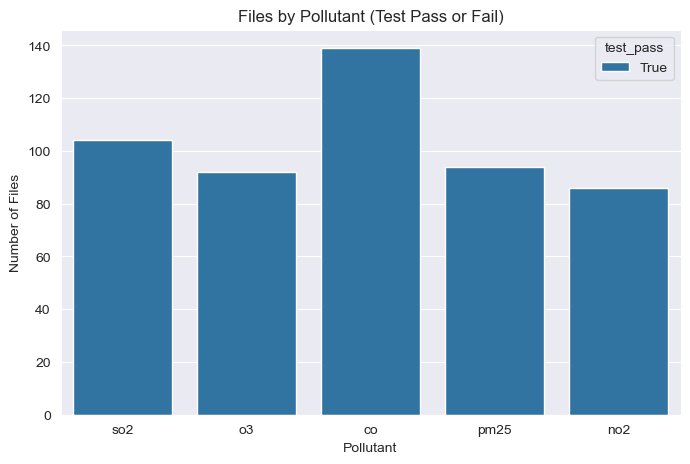

In [19]:
# %%
if df_report is not None and not df_report.empty and "pollutant" in df_report.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_report, x="pollutant", hue="test_pass")
    plt.title("Files by Pollutant (Test Pass or Fail)")
    plt.xlabel("Pollutant")
    plt.ylabel("Number of Files")
    plt.show()
else:
    print("No 'pollutant' column or empty df_report to analyze pollutant distribution.")

In [20]:
# %% [markdown]
# ### 6.2 Quick Check Eksik Kolon Analizi
#
# Bazı projelerde `quick_check_limit` gibi bir değişken ile ilk birkaç dosyada ekstra log alınır.
# Eğer `notes` sütununda “Missing columns: […]” mesajı varsa, bunu regex ile yakalayarak eksik kolonların hangileri olduğunu tespit edebiliriz.

In [21]:
# %%
if df_report is not None and not df_report.empty and "notes" in df_report.columns:
    # quick_check_limit
    quick_n = config.get("data_check", {}).get("quick_check_limit", 5)
    quick_check_df = df_report.head(quick_n).copy()

    # 'notes' sütununu string'e çevirip NaN / None durumlarını temizleyelim
    quick_check_df['notes'] = quick_check_df['notes'].astype(str).fillna('')

    # Eksik kolonları yakalama (regex)
    missing_values = quick_check_df['notes'].apply(
        lambda x: re.findall(r"Missing columns: \[(.*?)\]", x)
    ).explode().dropna()

    # Her kayıtta birden çok kolon varsa, split edip patlatalım
    missing_values = missing_values.apply(lambda x: [col.strip() for col in x.split(',')])
    missing_columns_series = missing_values.explode().value_counts()

    if not missing_columns_series.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_columns_series.values, y=missing_columns_series.index)
        plt.title("Missing Columns Frequency (Quick Check)")
        plt.xlabel("Count")
        plt.ylabel("Column Names")
        plt.show()
    else:
        print("No missing columns found in quick check files.")
else:
    print("No 'notes' column or empty df_report. Skipping quick check analysis.")



No missing columns found in quick check files.


In [22]:
# %% [markdown]
# ### 6.2 Isı Haritası (Opsiyonel)
#
# - Raporun “row_count” ve “test_pass” gibi kolonlarını pivot’layarak ısı haritası oluşturabiliriz.
# - Geniş veri setlerinde ek istatistikleri de ısı haritasına dahil etmek isteyebilirsiniz.

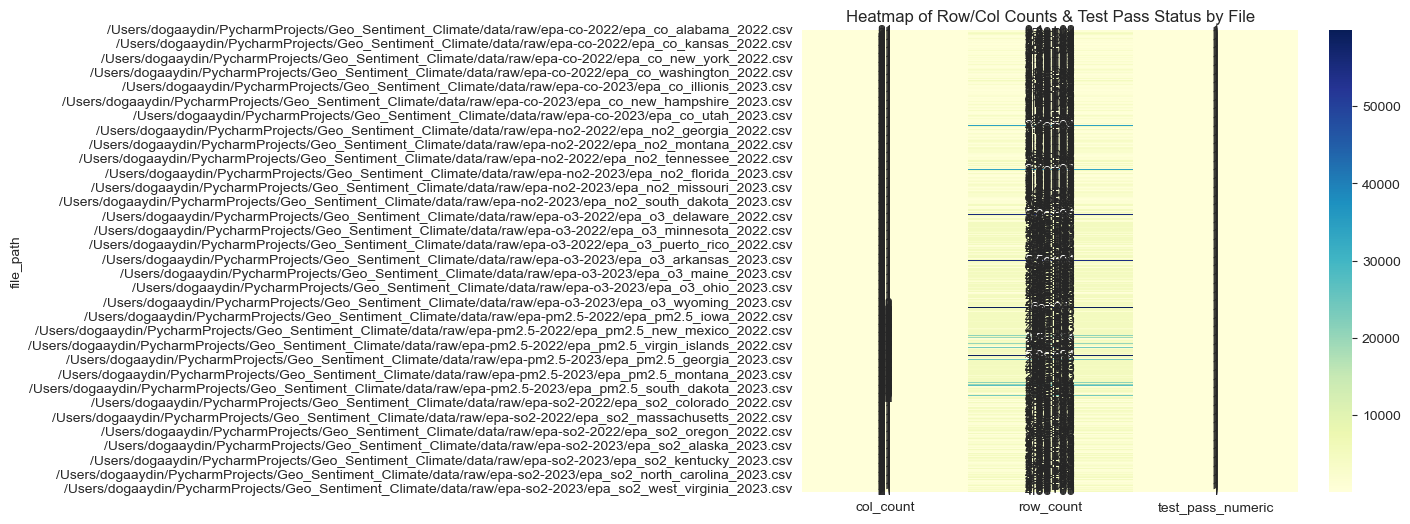

In [23]:

# %%
if df_report is not None and not df_report.empty:
    if "test_pass" in df_report.columns:
        pivot_df = df_report.copy()
        pivot_df['test_pass_numeric'] = pivot_df['test_pass'].apply(lambda x: 1 if x else 0)

        pivot_table = pivot_df.pivot_table(
            index='file_path',
            values=['row_count', 'col_count', 'test_pass_numeric'],
            aggfunc='mean'
        )

        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
        plt.title("Heatmap of Row/Col Counts & Test Pass Status by File")
        plt.show()
    else:
        print("'test_pass' column not found in df_report.")
else:
    print("No data in df_report to create a heatmap.")

In [24]:
# %% [markdown]
# ## 7. Gelişmiş Log Ekleme ve Raporlama
#
# - Bu aşamada, notebook içinde oluşan uyarı ve log mesajlarını da rapora eklemek isteyebilirsiniz.
# - Örneğin, “logların eksik olup olmadığı” veya “her dosya için ek uyarı notları” gibi ek sütunlar eklemek mümkündür.
# - Aynı zamanda rapora ek veri profilleme bilgileri (ortalama, std, min, max, vb.) dahil edilebilir.
#
# *İsteğe Bağlı:* Burada ek bir hücre açarak, log dosyasını okuyup rapor DataFrame’ine ekleyebilir veya
# “logger.warning / logger.error” count’larını rapora işleyebilirsiniz.

In [25]:
# %%
log_file_path = os.path.join(LOG_DIR, "data_check_notebook.log")
if os.path.exists(log_file_path):
    with open(log_file_path, "r", encoding="utf-8") as f:
        logs = f.readlines()
    print(f"Log file contains {len(logs)} lines.")
else:
    print("No log file found to analyze.")

Log file contains 2 lines.


In [26]:
# %% [markdown]
# ## 8. Sonuç ve Sonraki Adımlar
#
# Bu notebook ile:
# - **Gelişmiş `data_check.py`** modülünüzü çağırarak ham veri klasörünüzdeki tüm CSV dosyalarında
#   kirletici bazında **kolon varlığı**, **veri tipi**, **eksik veri**, **chunk bazlı okuma**, **örnekleme** gibi
#   pek çok kalite kontrolü gerçekleştirdik.
# - Üretilen raporu inceledik, eksik ve sorunlu alanları görselleştirdik.
# - Log dosyası üzerinden de ek bilgiler topladık.
#
# **Sonraki Adımlarda**:
# - Eksik verileri (ör. Site ID, CBSA Code vb.) **dosyalar arası** doldurma için `missing_handle.py` gibi bir modül.
# - Veri dönüşümlerine (ETL/ELT) devam edip `data_ingestion` aşamasıyla **kirletici bazında** ingestion.
# - Modelleme öncesi veriyi `data_clean.py`, `data_preprocessing.py` ile zenginleştirme.
#
# ---
#
# **İyi analizler!**